# TODO: Title
**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of the TODO's and/or use more than one cell to complete all the tasks.

## Data Preparation
**TODO:** Run the cell below to download the data.

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [1]:
%%capture

!pip install smdebug torch torchvision tqdm --no-cache-dir

In [66]:
# Importing Libraries for Data Preparation
import numpy as np
import pandas as pd
import boto3
import random
import shutil
import os
import json
import requests
from tqdm import tqdm

import torch
import sagemaker
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig
from sagemaker.debugger import ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.axes_grid1 import host_subplot
from PIL import Image
import io


In [4]:
# Create temp path for data location
local_data_path = "training_data"

# Function for data preparations
def data_preparation(local_data_path):
    s3_client = boto3.client('s3')
    
    with open('file_list.json', 'r') as f:
        d=json.load(f)
        
    for k, v in d.items():
        print(f"Downloading Images with {k} objects from")
        directory=os.path.join(local_data_path, k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

In [5]:
data_preparation(local_data_path)

100%|██████████| 1228/1228 [01:39<00:00, 12.31it/s]


100%|██████████| 2299/2299 [03:10<00:00, 12.08it/s]


100%|██████████| 2666/2666 [03:42<00:00, 11.98it/s]


100%|██████████| 2373/2373 [03:15<00:00, 12.12it/s]


100%|██████████| 1875/1875 [02:33<00:00, 12.24it/s]


## Dataset
**TODO:** Explain what dataset you are using for this project. Give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understanding of it. You can find more information about the data [here](https://registry.opendata.aws/amazon-bin-imagery/).

Downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder.
```
$ tree .
.
├── test
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
├── train
│   ├── 1
│   ├── 2
│   ├── 3
│   ├── 4
│   └── 5
└── valid
    ├── 1
    ├── 2
    ├── 3
    ├── 4
    └── 5
````

In [6]:
# Perform data exploration
main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [7]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


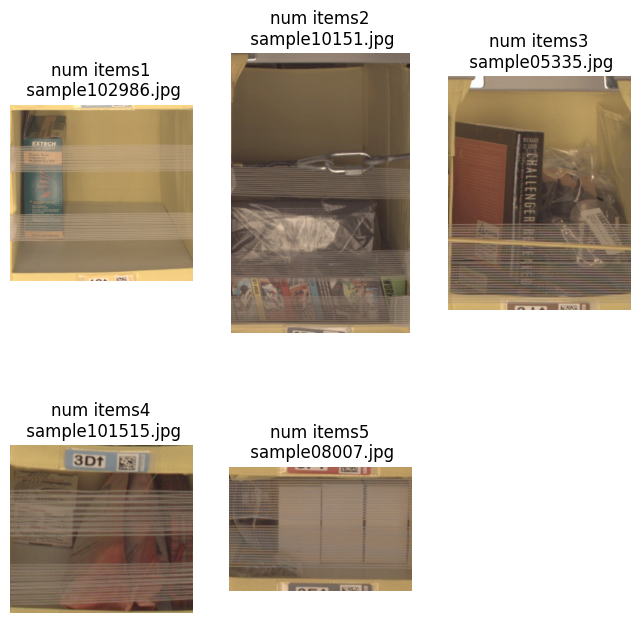

In [22]:
# Data visualzation
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2

for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample" + img_filename
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
    
plt.show()
figure.savefig('sample_dataset.png')

In [12]:
# Dataset split into Train: 60%, Test: 20%, Valid: 20%
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}

for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [13]:
import shutil

In [14]:
split_localdata_path = 'train_test_valid_split'

In [15]:
# 
try:
    os.mkdir(split_localdata_path)
    os.mkdir(os.path.join(split_localdata_path, 'valid'))
    os.mkdir(os.path.join(split_localdata_path, 'test'))
    os.mkdir(os.path.join(split_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(split_localdata_path, 'valid', key))
        os.mkdir(os.path.join(split_localdata_path, 'test', key))
        os.mkdir(os.path.join(split_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(split_localdata_path,'train', key, filename))
                
print('Finished..')

Finished..


In [3]:
# General macros
session = sagemaker.Session()
print("Default Session: {}".format(session))
region = session.boto_region_name
print("AWS Region     : {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn        : {}".format(role))

Default Session: <sagemaker.session.Session object at 0x7ff03faa1dd0>
Default Bucket : sagemaker-us-east-1-933845045900
AWS Region     : us-east-1
RoleArn        : arn:aws:iam::933845045900:role/service-role/AmazonSageMaker-ExecutionRole-20230130T210045


In [16]:
#arn:aws:s3:::object-count-tracking-using-aws-sagemaker
#s3://object-count-tracking-using-aws-sagemaker/
bucket_path = "s3://object-count-tracking-using-aws-sagemaker/"
dataset_path = os.path.join(bucket_path, split_localdata_path)
print(f"S3 bucket path    : {bucket_path}")
print(f"Dataset path in S3: {dataset_path}")

S3 bucket path    : s3://object-count-tracking-using-aws-sagemaker/
Dataset path in S3: s3://object-count-tracking-using-aws-sagemaker/train_test_valid_split


In [17]:
os.environ["DATASET_PATH"] = dataset_path
os.environ["DATASET_ORIGIN_PATH"] = split_localdata_path

In [19]:
# Upload the data to AWS S3 using sync
# https://awscli.amazonaws.com/v2/documentation/api/latest/reference/s3/sync.html
!aws s3 sync ${DATASET_ORIGIN_PATH} ${DATASET_PATH} --only-show-errors

### Hyperparameter Tuning

This part involves using external python scripts:
1. Hyperparameters tuning through `hpo.py`
2. Tain with optional concurrency `train.py`

In [63]:
# Importing Libraries needed for Model Training
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig
from sagemaker.debugger import ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
from sagemaker.predictor import Predictor
from sagemaker.pytorch import PyTorchModel
from PIL import Image
import io
import torch
import numpy as np

In [23]:
# Hyperparameter search space
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512])
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [25]:
# Training estimator
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='Amazon buckets HP search',
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=10,
    objective_type=objective_type
)

In [26]:
# Defined macros
os.environ["SM_CHANNEL_TRAINING"] = dataset_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path + "/model/" # where model will be stored

In [27]:
# Fit  estimator
tuner.fit({"training": dataset_path}, wait = True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [28]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-230209-0721


In [30]:
exp = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=latest_hyperparameter_tuning_job_name)

jobs = exp.dataframe()

In [31]:
jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
3,"""128""",0.096048,pytorch-training-230209-0721-007-2924c748,Completed,45.246983,2023-02-09 07:22:55+00:00,2023-02-09 07:30:43+00:00,468.0
1,"""256""",0.013362,pytorch-training-230209-0721-009-e642f64e,Completed,13.012752,2023-02-09 07:22:56+00:00,2023-02-09 07:31:04+00:00,488.0
2,"""256""",0.010037,pytorch-training-230209-0721-008-74918001,Completed,6.544734,2023-02-09 07:22:57+00:00,2023-02-09 07:31:01+00:00,484.0
7,"""64""",0.010193,pytorch-training-230209-0721-003-36bb93f6,Completed,1.797816,2023-02-09 07:22:46+00:00,2023-02-09 07:30:15+00:00,449.0
4,"""128""",0.001987,pytorch-training-230209-0721-006-d72c50c4,Completed,1.697828,2023-02-09 07:22:54+00:00,2023-02-09 07:30:28+00:00,454.0
5,"""64""",0.002488,pytorch-training-230209-0721-005-cdb0e388,Completed,1.697160,2023-02-09 07:22:50+00:00,2023-02-09 07:30:19+00:00,449.0
9,"""32""",0.019110,pytorch-training-230209-0721-001-03113e74,Completed,1.683433,2023-02-09 07:22:52+00:00,2023-02-09 07:30:05+00:00,433.0
0,"""512""",0.001901,pytorch-training-230209-0721-010-b8ea65f5,Completed,1.659610,2023-02-09 07:23:27+00:00,2023-02-09 07:32:45+00:00,558.0
6,"""64""",0.002313,pytorch-training-230209-0721-004-dae311c5,Completed,1.635567,2023-02-09 07:22:51+00:00,2023-02-09 07:30:56+00:00,485.0
8,"""32""",0.005339,pytorch-training-230209-0721-002-789d5561,Completed,1.588916,2023-02-09 07:22:47+00:00,2023-02-09 07:30:00+00:00,433.0


In [32]:
best_estimator=tuner.best_estimator()


2023-02-09 07:30:02 Starting - Preparing the instances for training
2023-02-09 07:30:02 Downloading - Downloading input data
2023-02-09 07:30:02 Training - Training image download completed. Training in progress.
2023-02-09 07:30:02 Uploading - Uploading generated training model
2023-02-09 07:30:02 Completed - Resource retained for reuse


In [33]:
# Best hyperparameters
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.005339291333527525',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Amazon buckets HP search-2023-02-09-07-21-30-880"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-933845045900/Amazon buckets HP search-2023-02-09-07-21-30-880/source/sourcedir.tar.gz"'}

### Model Profiling and Debugging

In [34]:
# Update values
hyperparameter_values = {
    "learning_rate": 0.005339291333527525,
    "batch_size": 32,
}
hyperparameter_values

{'learning_rate': 0.005339291333527525, 'batch_size': 32}

In [35]:
# Set debug rules
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [36]:
# Set profile rules & hooks
debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [37]:
# Create estimator
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [38]:
# Dataset location
os.environ["SM_CHANNEL_TRAINING"] = dataset_path
# model location
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" 

In [39]:
# Fit an estimator
estimator.fit({"training": dataset_path}, wait= True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-02-09-08-12-58-820


2023-02-09 08:12:59 Starting - Starting the training job...
2023-02-09 08:13:23 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2023-02-09 08:14:23 Downloading - Downloading input data...
2023-02-09 08:14:51 Training - Downloading the training image...
2023-02-09 08:15:23 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-02-09 08:15:27,709 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-02-09 08:15:27,712 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-02-09 08:15:27,720 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-02-09 08:15:27,722 sagemaker_pytorch_container.training INFO  

In [40]:
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

Job name: pytorch-training-2023-02-09-08-12-58-820
Debug artifacts path s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-09-08-12-58-820/debug-output


In [41]:
# Print the latest training job’s rule summary in real time
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f'job_name: {job_name}')
print(f'client: {client}')

job_name: pytorch-training-2023-02-09-08-12-58-820
client: <botocore.client.SageMaker object at 0x7ff0344b0390>


In [46]:
# Check Training Performance
trial = create_trial(debug_artifacts_path)

[2023-02-09 09:04:43.070 ip-172-16-120-15.ec2.internal:8135 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-02-09 09:04:43.109 ip-172-16-120-15.ec2.internal:8135 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-09-08-12-58-820/debug-output


In [48]:
print("No of TRAIN datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))))
print("No of EVAL datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))))

[2023-02-09 09:06:46.965 ip-172-16-120-15.ec2.internal:8135 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-02-09 09:06:47.983 ip-172-16-120-15.ec2.internal:8135 INFO trial.py:210] Loaded all steps
No of TRAIN datapoints 40
No of EVAL datapoints 80


In [53]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded train data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded evaluation data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (train)")
    par.set_xlabel("Steps (eval)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed train plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed eval plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show();
    fig.savefig('training_values.png')

loaded train data
loaded evaluation data
completed train plot
completed eval plot


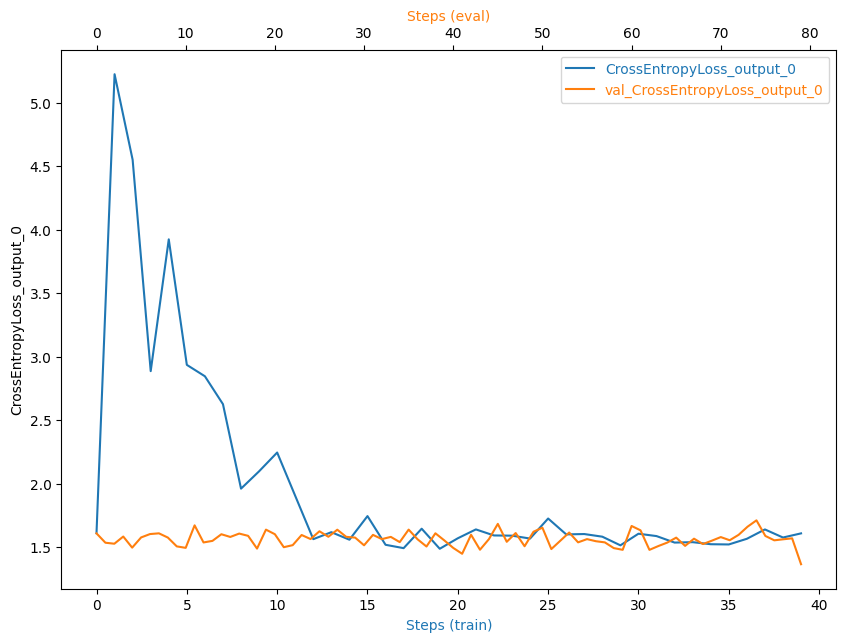

In [59]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

### Model Deploying and Querying

* Running inference on trained model using sample image and check if the model is actually working.

* Steps:

    1. Locate model
    2. Create ImagePredictor to run the model anywhere with help of `inference.py`
    3. Create AWS endpoint
    4. Use endpoint for inference
    5. Delete endpoint after successful  infrence

In [76]:
# Model location
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-933845045900/pytorch-training-2023-02-09-08-12-58-820/output/model.tar.gz


In [77]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

In [78]:
# Deploy model to an endpoint
# Create ImagePredictor
class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [79]:
# Create pytorch model
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [80]:
# Run prediction on the endpoint
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2023-02-09-10-04-01-758
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2023-02-09-10-04-02-393
INFO:sagemaker:Creating endpoint with name pytorch-inference-2023-02-09-10-04-02-393


------!

In [142]:
# Plot requested image

with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)


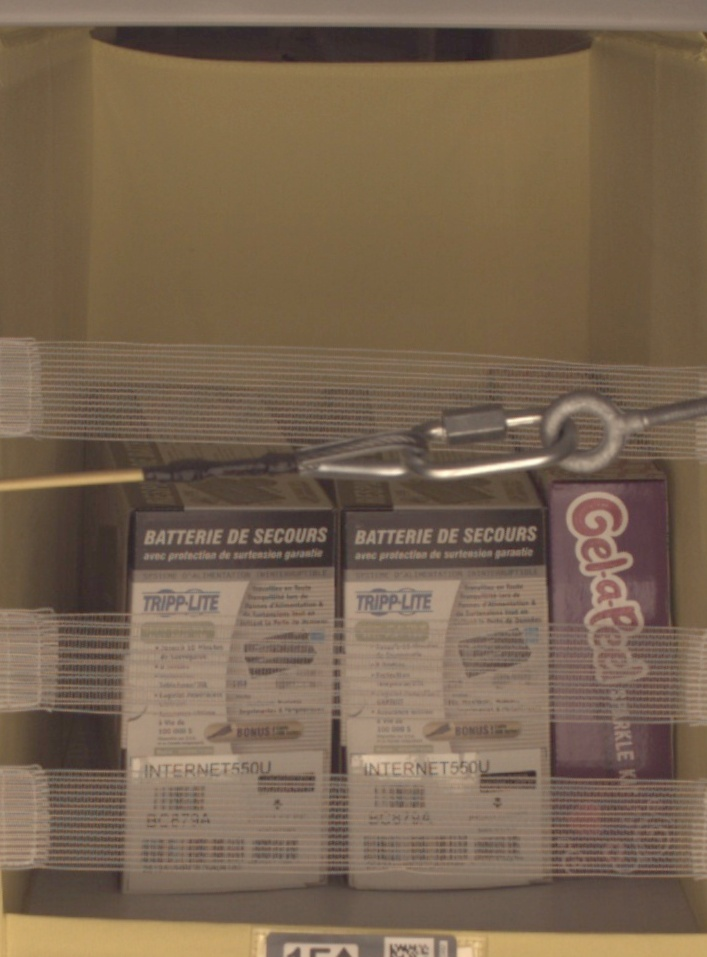

In [147]:
Image.open(io.BytesIO(img_bytes))

In [154]:
print("Expected answer: 3")

Expected answer: 3


In [148]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [149]:
print("Raw prediction result:")
print(response)

Raw prediction result:
[[0.019855573773384094, 0.34309279918670654, 0.7109078168869019, 0.6135687828063965, -0.08671106398105621]]


In [150]:
object_count_range = [1,2,3,4,5]

In [168]:
labeled_predictions = dict(zip(object_count_range, response[-1]))
print("Labeled predictions: ", labeled_predictions)

Labeled predictions:  {1: 0.019855573773384094, 2: 0.34309279918670654, 3: 0.7109078168869019, 4: 0.6135687828063965, 5: -0.08671106398105621}


In [178]:
print("Most likely answer: {} with probability {}".format(max(labeled_predictions, key=labeled_predictions.get)),max(labeled_predictions.values())))

SyntaxError: invalid syntax (1620859860.py, line 1)

In [177]:
print("Predictor Answer:", max(labeled_predictions, key=labeled_predictions.get))

Predictor Answer: 3


In [ ]:
# Shutdown/delete endpoint once your work is done
predictor.delete_endpoint()